# Author: Aditya Yadav

# Notebook 6: Naive Bayes for Smoking Prediction

In this notebook, we'll implement and evaluate Naive Bayes classifiers for predicting smoking status based on health indicators. We'll use the cleaned datasets prepared in Notebook 1.

## Understanding Naive Bayes

Naive Bayes is a family of probabilistic classifiers based on Bayes' theorem with the "naive" assumption of conditional independence between features. Despite this simplifying assumption, Naive Bayes performs surprisingly well in many real-world situations.

### How Naive Bayes Works:
1. It calculates the probability of each class based on the training data (prior probability)
2. For each feature, it calculates the conditional probability of that feature given each class
3. For a new observation, it applies Bayes' theorem to calculate the probability of each class given the feature values
4. It selects the class with the highest probability as the prediction

### Types of Naive Bayes Classifiers:
- **Gaussian Naive Bayes**: Assumes features follow a normal distribution (suitable for continuous data)
- **Bernoulli Naive Bayes**: Designed for binary/boolean features
- **Multinomial Naive Bayes**: Designed for discrete count data (e.g., term frequencies in text)
- **Complement Naive Bayes**: An adaptation of Multinomial NB designed for imbalanced datasets

### Advantages of Naive Bayes:
- Simple, fast, and efficient
- Works well with high-dimensional data
- Performs surprisingly well even when the independence assumption is violated
- Requires less training data than many other classifiers
- Provides probability estimates

### Limitations of Naive Bayes:
- The independence assumption is often unrealistic
- Performance can degrade when features are highly correlated
- May be outperformed by more sophisticated models on complex problems
- Zero frequency problem (when a feature value doesn't occur with a class in the training data)

Since our dataset contains continuous health indicators, Gaussian Naive Bayes is a natural choice, but we'll compare multiple variants to find the most suitable one for our smoking prediction task.

## 1. Import Libraries and Load Data

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For Naive Bayes models
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  # For non-Gaussian variants which need non-negative features
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Set random seed for reproducibility
RANDOM_STATE = 42

# Set up visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Load the full and reduced datasets
df_full = pd.read_csv('smoking_cleaned_full.csv')
df_reduced = pd.read_csv('smoking_cleaned_reduced.csv')

# Display basic information about the datasets
print(f"Full dataset shape: {df_full.shape}")
print(f"Reduced dataset shape: {df_reduced.shape}")

# Verify that both datasets have the target variable
print(f"\nTarget variable 'smoking' distribution in full dataset:\n{df_full['smoking'].value_counts()}")
print(f"\nTarget variable 'smoking' distribution in reduced dataset:\n{df_reduced['smoking'].value_counts()}")

Full dataset shape: (44084, 30)
Reduced dataset shape: (44084, 16)

Target variable 'smoking' distribution in full dataset:
smoking
0    27972
1    16112
Name: count, dtype: int64

Target variable 'smoking' distribution in reduced dataset:
smoking
0    27972
1    16112
Name: count, dtype: int64


## 2. Data Preparation for Naive Bayes

For Gaussian Naive Bayes, we don't need to scale the features because it works with the raw distribution of values. However, for other Naive Bayes variants (MultinomialNB and ComplementNB), we need non-negative features. We'll prepare the data for both scenarios.

In [3]:
# Separate features and target for both datasets
X_full = df_full.drop('smoking', axis=1)
y_full = df_full['smoking']

X_reduced = df_reduced.drop('smoking', axis=1)
y_reduced = df_reduced['smoking']

# Split the data into training and testing sets
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=RANDOM_STATE, stratify=y_full
)

X_reduced_train, X_reduced_test, y_reduced_train, y_reduced_test = train_test_split(
    X_reduced, y_reduced, test_size=0.2, random_state=RANDOM_STATE, stratify=y_reduced
)

# For MultinomialNB and ComplementNB, we need non-negative features
# Let's create MinMaxScaled versions (0 to 1 range) for those variants
scaler_full = MinMaxScaler(feature_range=(0, 1))
X_full_train_non_negative = scaler_full.fit_transform(X_full_train)
X_full_test_non_negative = scaler_full.transform(X_full_test)

scaler_reduced = MinMaxScaler(feature_range=(0, 1))
X_reduced_train_non_negative = scaler_reduced.fit_transform(X_reduced_train)
X_reduced_test_non_negative = scaler_reduced.transform(X_reduced_test)

print("Data preparation for Naive Bayes completed successfully.")
print(f"Training set size: {X_full_train.shape[0]} samples")
print(f"Testing set size: {X_full_test.shape[0]} samples")
print(f"Full feature set: {X_full.shape[1]} features")
print(f"Reduced feature set: {X_reduced.shape[1]} features")

Data preparation for Naive Bayes completed successfully.
Training set size: 35267 samples
Testing set size: 8817 samples
Full feature set: 29 features
Reduced feature set: 15 features


## 3. Comparing Different Naive Bayes Variants

Let's compare different Naive Bayes variants to find the most suitable one for our task. We'll test:

1. **Gaussian Naive Bayes (GaussianNB)**: Assumes features follow a normal distribution - suitable for continuous data
2. **Bernoulli Naive Bayes (BernoulliNB)**: Designed for binary/boolean features but can work with continuous data after binarization
3. **Multinomial Naive Bayes (MultinomialNB)**: Designed for discrete count data - requires non-negative features
4. **Complement Naive Bayes (ComplementNB)**: Adaptation of MultinomialNB for imbalanced datasets - also requires non-negative features

We'll evaluate each variant on the reduced feature set (for speed) and select the best one.

In [4]:
# List of Naive Bayes variants to test
nb_variants = [
    ('Gaussian NB', GaussianNB(), X_reduced_train),
    ('Bernoulli NB', BernoulliNB(), X_reduced_train_non_negative),
    ('Multinomial NB', MultinomialNB(), X_reduced_train_non_negative),
    ('Complement NB', ComplementNB(), X_reduced_train_non_negative)
]

# Dictionary to store results
nb_results = {}

print("Comparing different Naive Bayes variants...")
for name, model, X_train in nb_variants:
    try:
        # Train the model
        model.fit(X_train, y_reduced_train)
        
        # Get appropriate test data
        X_test = X_reduced_test if name == 'Gaussian NB' else X_reduced_test_non_negative
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_reduced_test, y_pred)
        
        # Store results
        nb_results[name] = accuracy
        
        print(f"{name}: Accuracy = {accuracy:.4f}")
    except Exception as e:
        print(f"Error with {name}: {str(e)}")

# Find the best variant
best_nb_name = max(nb_results, key=nb_results.get)
print(f"\nBest Naive Bayes variant: {best_nb_name} with accuracy of {nb_results[best_nb_name]:.4f}")

Comparing different Naive Bayes variants...
Gaussian NB: Accuracy = 0.7062
Bernoulli NB: Accuracy = 0.7000
Multinomial NB: Accuracy = 0.6346
Complement NB: Accuracy = 0.7057

Best Naive Bayes variant: Gaussian NB with accuracy of 0.7062


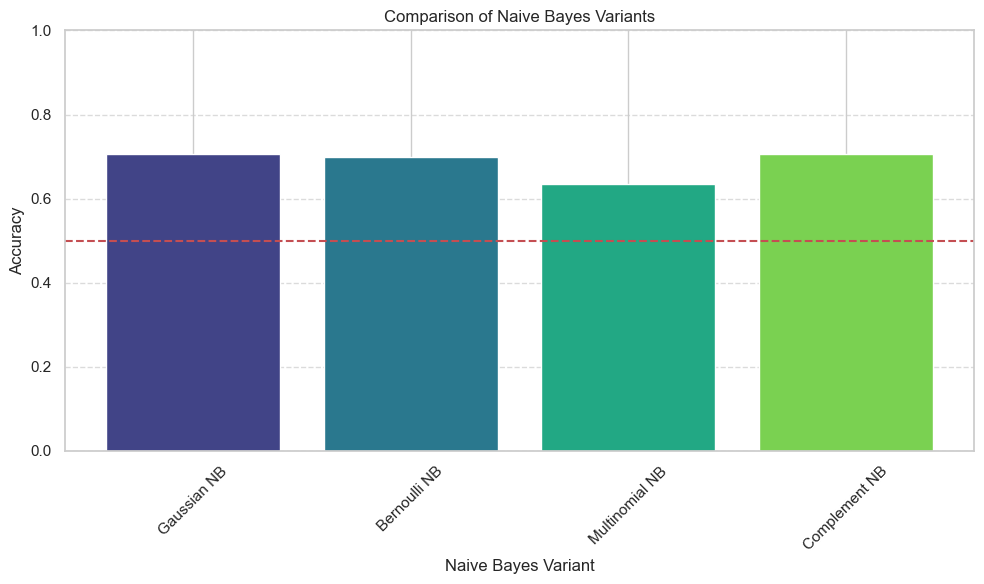

In [5]:
# Visualize comparison of Naive Bayes variants
plt.figure(figsize=(10, 6))
plt.bar(nb_results.keys(), nb_results.values(), color=sns.color_palette("viridis", len(nb_results)))
plt.axhline(y=0.5, color='r', linestyle='--', label='Random Guess (0.5)')
plt.ylim(0, 1)
plt.xlabel('Naive Bayes Variant')
plt.ylabel('Accuracy')
plt.title('Comparison of Naive Bayes Variants')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 4. Create Function for Final Model Evaluation

In [6]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred, y_prob=None):
    """Calculate and return performance metrics for a classification model."""
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # ROC AUC (if probability predictions are available)
    roc_auc = roc_auc_score(y_true, y_prob) if y_prob is not None else None
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

## 5. Training the Best Naive Bayes Model

Now that we've identified the best Naive Bayes variant, let's train it on both the full and reduced feature sets to evaluate its performance.

In [7]:
# Create instances of the best Naive Bayes variant
if best_nb_name == 'Gaussian NB':
    nb_full = GaussianNB()
    nb_reduced = GaussianNB()
    X_full_train_prepared = X_full_train
    X_full_test_prepared = X_full_test
    X_reduced_train_prepared = X_reduced_train
    X_reduced_test_prepared = X_reduced_test
elif best_nb_name == 'Bernoulli NB':
    nb_full = BernoulliNB()
    nb_reduced = BernoulliNB()
    X_full_train_prepared = X_full_train_non_negative
    X_full_test_prepared = X_full_test_non_negative
    X_reduced_train_prepared = X_reduced_train_non_negative
    X_reduced_test_prepared = X_reduced_test_non_negative
elif best_nb_name == 'Multinomial NB':
    nb_full = MultinomialNB()
    nb_reduced = MultinomialNB()
    X_full_train_prepared = X_full_train_non_negative
    X_full_test_prepared = X_full_test_non_negative
    X_reduced_train_prepared = X_reduced_train_non_negative
    X_reduced_test_prepared = X_reduced_test_non_negative
elif best_nb_name == 'Complement NB':
    nb_full = ComplementNB()
    nb_reduced = ComplementNB()
    X_full_train_prepared = X_full_train_non_negative
    X_full_test_prepared = X_full_test_non_negative
    X_reduced_train_prepared = X_reduced_train_non_negative
    X_reduced_test_prepared = X_reduced_test_non_negative

# Train the models
print(f"Training {best_nb_name} with full feature set...")
nb_full.fit(X_full_train_prepared, y_full_train)

print(f"Training {best_nb_name} with reduced feature set...")
nb_reduced.fit(X_reduced_train_prepared, y_reduced_train)

# Make predictions
y_full_pred = nb_full.predict(X_full_test_prepared)
y_reduced_pred = nb_reduced.predict(X_reduced_test_prepared)

# Get probability predictions
y_full_prob = nb_full.predict_proba(X_full_test_prepared)[:, 1]
y_reduced_prob = nb_reduced.predict_proba(X_reduced_test_prepared)[:, 1]

# Evaluate performance
full_metrics = evaluate_model(y_full_test, y_full_pred, y_full_prob)
reduced_metrics = evaluate_model(y_reduced_test, y_reduced_pred, y_reduced_prob)

# Display results
print(f"\n{best_nb_name} with Full Feature Set:")
print(f"Accuracy: {full_metrics['accuracy']:.4f}")
print(f"Precision: {full_metrics['precision']:.4f}")
print(f"Recall: {full_metrics['recall']:.4f}")
print(f"F1 Score: {full_metrics['f1_score']:.4f}")
print(f"ROC AUC: {full_metrics['roc_auc']:.4f}")

print(f"\n{best_nb_name} with Reduced Feature Set:")
print(f"Accuracy: {reduced_metrics['accuracy']:.4f}")
print(f"Precision: {reduced_metrics['precision']:.4f}")
print(f"Recall: {reduced_metrics['recall']:.4f}")
print(f"F1 Score: {reduced_metrics['f1_score']:.4f}")
print(f"ROC AUC: {reduced_metrics['roc_auc']:.4f}")

Training Gaussian NB with full feature set...
Training Gaussian NB with reduced feature set...

Gaussian NB with Full Feature Set:
Accuracy: 0.7050
Precision: 0.5702
Recall: 0.7831
F1 Score: 0.6599
ROC AUC: 0.7925

Gaussian NB with Reduced Feature Set:
Accuracy: 0.7062
Precision: 0.5680
Recall: 0.8191
F1 Score: 0.6708
ROC AUC: 0.7909


## 6. Understanding the Evaluation Metrics

Let's understand what each metric means in the context of our smoking prediction problem:

1. **Accuracy**: The proportion of correct predictions (both smokers and non-smokers correctly identified) out of all predictions. While intuitive, accuracy can be misleading in imbalanced datasets like ours (63% non-smokers vs. 37% smokers).

2. **Precision**: The proportion of true positive predictions (correctly identified smokers) among all positive predictions. In our context: "When the Naive Bayes model predicts someone is a smoker, how often is it right?" High precision means fewer false positives (non-smokers incorrectly classified as smokers).

3. **Recall (Sensitivity)**: The proportion of true positive predictions (correctly identified smokers) among all actual smokers. In our context: "Of all actual smokers, how many did the Naive Bayes model correctly identify?" High recall means fewer false negatives (smokers incorrectly classified as non-smokers).

4. **F1 Score**: The harmonic mean of precision and recall, providing a single metric that balances both concerns. This is particularly useful in our case with moderate class imbalance, as it gives equal importance to both precision and recall.

5. **ROC AUC**: Area Under the Receiver Operating Characteristic curve, which measures the model's ability to distinguish between smokers and non-smokers across all possible classification thresholds. Values range from 0.5 (no discriminative power, equivalent to random guessing) to 1.0 (perfect discrimination).

The choice of which metric to prioritize depends on the specific application:
- For applications where false positives are costly (e.g., unnecessary medical interventions), precision should be prioritized.
- For public health screening where missing smokers is more concerning, recall would be more important.
- In balanced scenarios, F1 score and ROC AUC provide good overall assessments of model performance.

## 7. Visualizing Model Performance

Confusion Matrix for Full Feature Set:


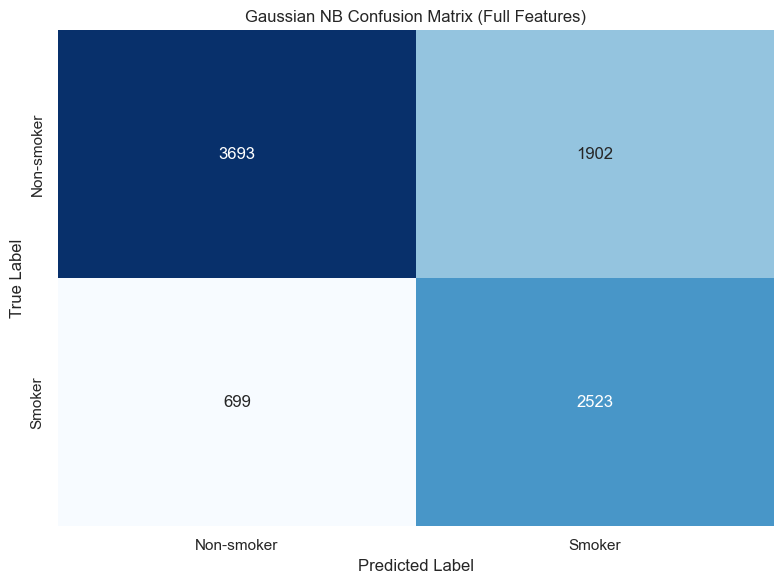

Specificity (True Negative Rate): 0.6601
Negative Predictive Value: 0.8408

Confusion Matrix for Reduced Feature Set:


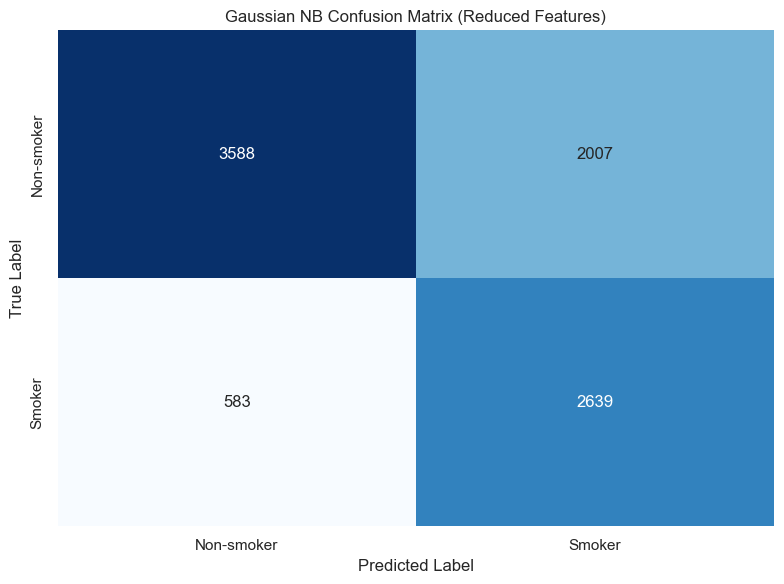

Specificity (True Negative Rate): 0.6413
Negative Predictive Value: 0.8602


In [8]:
# Function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
               xticklabels=['Non-smoker', 'Smoker'],
               yticklabels=['Non-smoker', 'Smoker'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    # Calculate and display derived metrics
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)  # True negative rate
    npv = tn / (tn + fn)  # Negative predictive value
    print(f"Specificity (True Negative Rate): {specificity:.4f}")
    print(f"Negative Predictive Value: {npv:.4f}")

# Function to plot ROC curves
def plot_roc_curve(y_true, y_prob, label):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Display confusion matrices
print("Confusion Matrix for Full Feature Set:")
plot_confusion_matrix(y_full_test, y_full_pred, f'{best_nb_name} Confusion Matrix (Full Features)')

print("\nConfusion Matrix for Reduced Feature Set:")
plot_confusion_matrix(y_reduced_test, y_reduced_pred, f'{best_nb_name} Confusion Matrix (Reduced Features)')

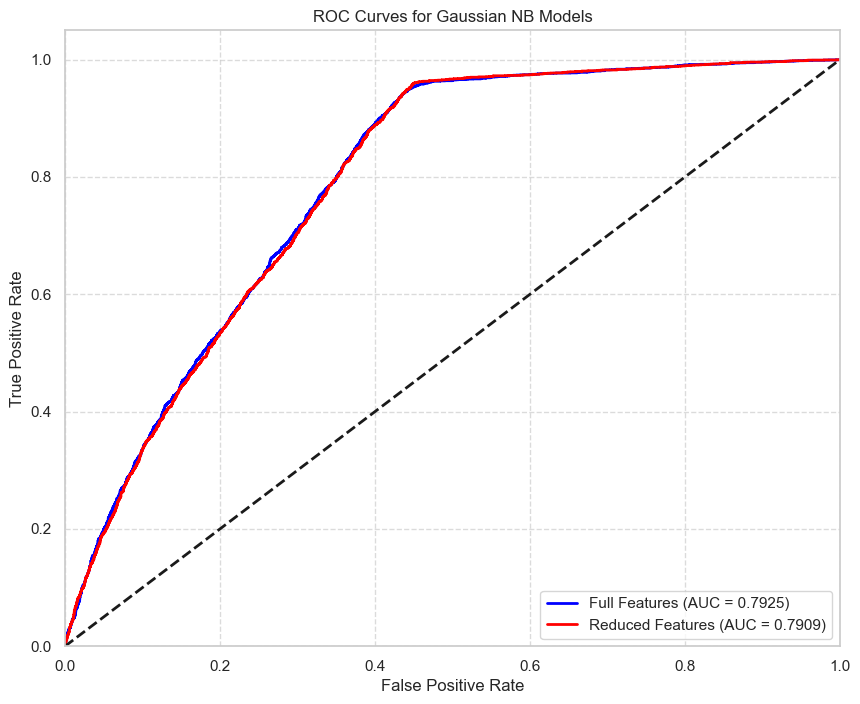

In [9]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Plot ROC curve for the full feature model
fpr_full, tpr_full, roc_auc_full = plot_roc_curve(y_full_test, y_full_prob, 'Full')
plt.plot(fpr_full, tpr_full, label=f'Full Features (AUC = {roc_auc_full:.4f})', lw=2, color='blue')

# Plot ROC curve for the reduced feature model
fpr_reduced, tpr_reduced, roc_auc_reduced = plot_roc_curve(y_reduced_test, y_reduced_prob, 'Reduced')
plt.plot(fpr_reduced, tpr_reduced, label=f'Reduced Features (AUC = {roc_auc_reduced:.4f})', lw=2, color='red')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves for {best_nb_name} Models')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## 8. Comparison of Feature Sets

Let's directly compare the performance of our full and reduced feature sets to see how much predictive power we retain with fewer features:

In [10]:
# Create a comparison DataFrame
metrics_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Full Features': [
        full_metrics['accuracy'],
        full_metrics['precision'],
        full_metrics['recall'],
        full_metrics['f1_score'],
        full_metrics['roc_auc']
    ],
    'Reduced Features': [
        reduced_metrics['accuracy'],
        reduced_metrics['precision'],
        reduced_metrics['recall'],
        reduced_metrics['f1_score'],
        reduced_metrics['roc_auc']
    ]
})

# Calculate differences and percentage changes
metrics_comparison['Absolute Difference'] = metrics_comparison['Full Features'] - metrics_comparison['Reduced Features']
metrics_comparison['Percentage Change (%)'] = (metrics_comparison['Absolute Difference'] / metrics_comparison['Full Features']) * 100

# Display the comparison
print(f"Comparison of {best_nb_name} Performance: Full vs. Reduced Feature Sets")
metrics_comparison.set_index('Metric')

Comparison of Gaussian NB Performance: Full vs. Reduced Feature Sets


,Full Features,Reduced Features,Absolute Difference,Percentage Change (%)
Metric,,,,
Accuracy,0.705002,0.706249,-0.001248,-0.176963
Precision,0.570169,0.568015,0.002154,0.377781
Recall,0.783054,0.819056,-0.036002,-4.597701
F1 Score,0.659867,0.670819,-0.010952,-1.659713
ROC AUC,0.792524,0.790882,0.001641,0.207116


<Figure size 1200x800 with 0 Axes>

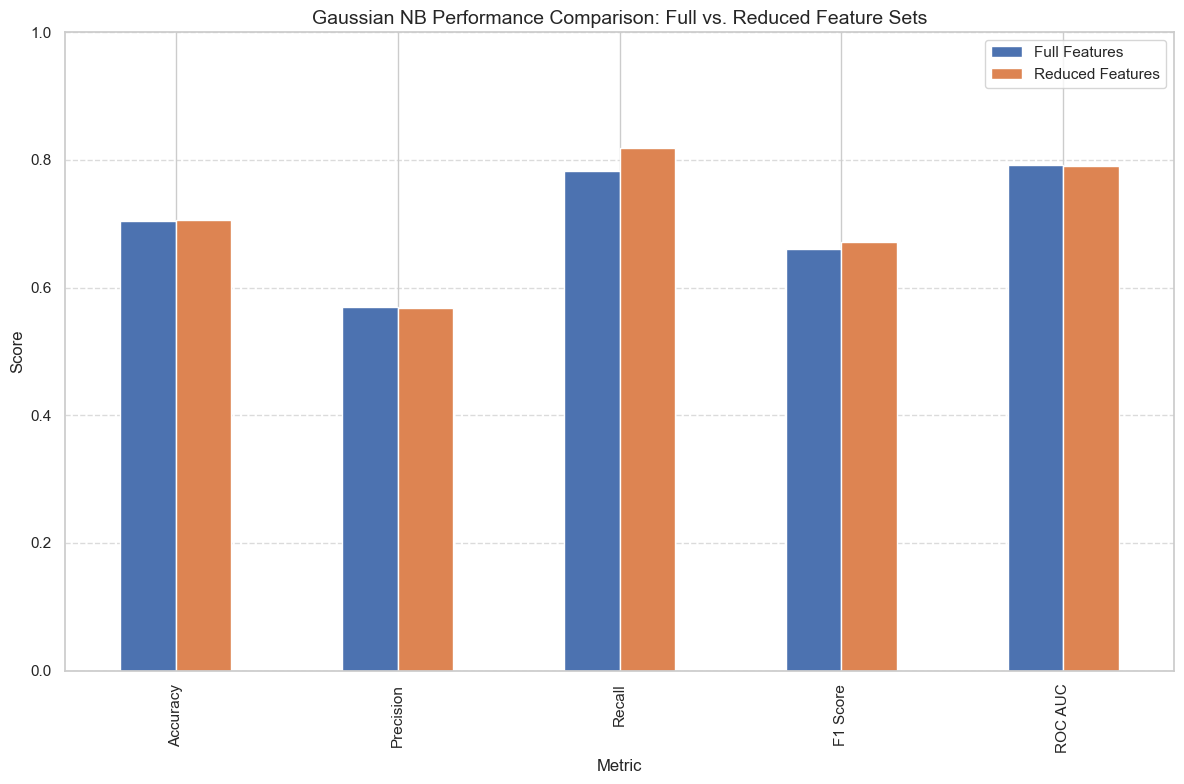

In [11]:
# Visualize the comparison
plt.figure(figsize=(12, 8))
metrics_comparison.set_index('Metric').loc[:, ['Full Features', 'Reduced Features']].plot(kind='bar')
plt.title(f'{best_nb_name} Performance Comparison: Full vs. Reduced Feature Sets', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.ylim([0, 1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## 9. Save Results for Comparison with Other Models

Let's save our Naive Bayes model performance metrics to CSV files for later comparison with other models:

In [12]:
# Create DataFrames for saving results
nb_full_results = pd.DataFrame({
    'Model': [best_nb_name],
    'Feature_Set': ['Full'],
    'Accuracy': [full_metrics['accuracy']],
    'Precision': [full_metrics['precision']],
    'Recall': [full_metrics['recall']],
    'F1_Score': [full_metrics['f1_score']],
    'ROC_AUC': [full_metrics['roc_auc']]
})

nb_reduced_results = pd.DataFrame({
    'Model': [best_nb_name],
    'Feature_Set': ['Reduced'],
    'Accuracy': [reduced_metrics['accuracy']],
    'Precision': [reduced_metrics['precision']],
    'Recall': [reduced_metrics['recall']],
    'F1_Score': [reduced_metrics['f1_score']],
    'ROC_AUC': [reduced_metrics['roc_auc']]
})

# Combine results
nb_results = pd.concat([nb_full_results, nb_reduced_results], ignore_index=True)

# Add hyperparameter information
nb_results['Hyperparameters'] = ["Default parameters", "Default parameters"]

# Save results to CSV
nb_results.to_csv('naive_bayes_model_results.csv', index=False)
print(f"Saved {best_nb_name} model results to naive_bayes_model_results.csv")

# Display the final results table
nb_results

Saved Gaussian NB model results to naive_bayes_model_results.csv


,Model,Feature_Set,Accuracy,Precision,Recall,F1_Score,ROC_AUC,Hyperparameters
0,Gaussian NB,Full,0.705002,0.570169,0.783054,0.659867,0.792524,Default parameters
1,Gaussian NB,Reduced,0.706249,0.568015,0.819056,0.670819,0.790882,Default parameters
